# 구현한 RAG 아키텍쳐

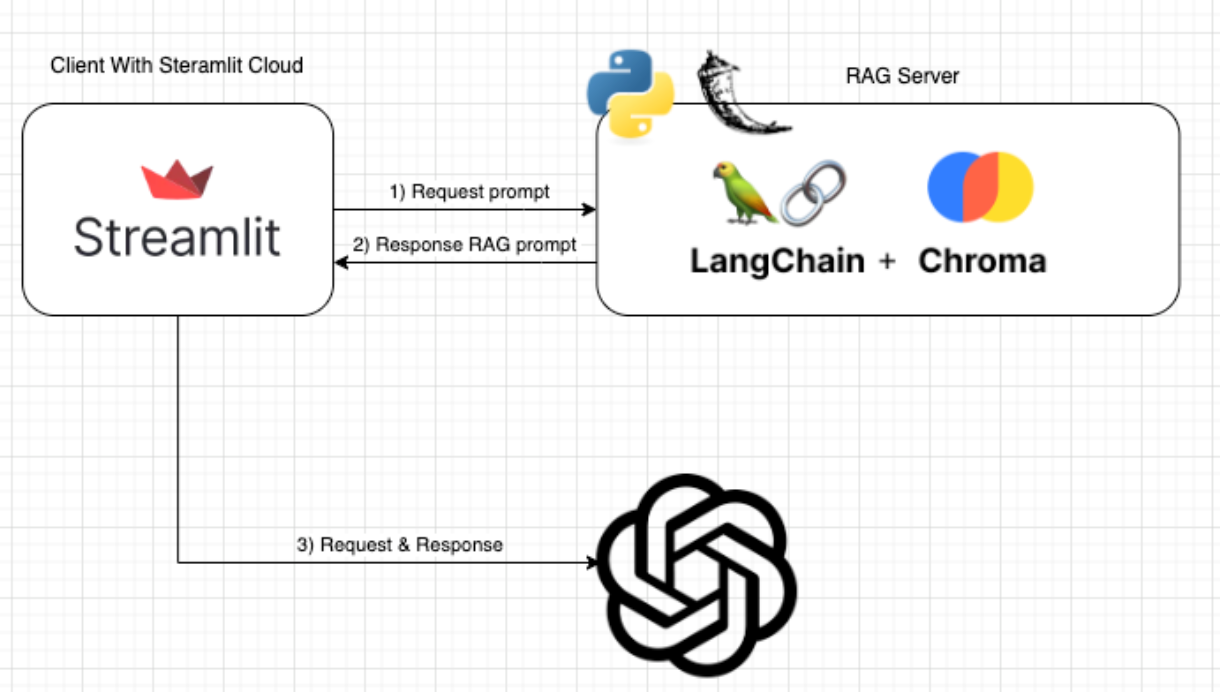

Flask는 복잡한 백엔드 작업을 처리하고  RESTful API를 통해 다양한 클라이언트에서 API로 접근할 수 있는 기능을 제공합니다. 

Streamlit은 사용자와 상호작용하는 대화형 UI와 데이터 시각화에 강점이 있습니다. 사용자 인터페이스(UI) 기능이 내장되어 있어 별도의 HTML, CSS, JavaScript 없이 시각적인 웹 애플리케이션을 구축할 수 있습니다.

이 프로젝트에서는 PDF 처리, 벡터 저장소 생성 등 백엔드 로직을 Flask로 처리하고, Streamlit을 통해 이를 사용자에게 인터페이스 형태로 제공하는 구조를 사용했습니다.

# 구현시 알아 두어야 할 사항

Streamlit은 데이터 입력시 전체 새로고침이 일어납니다.

Chromadb에 pdf 문서 내용을 vectorization & chunking 해줍니다.

db에서 similarity를 계산하여 가장 유사한 몇 개의 결과를 추출하게 됩니다.

그 결과를 다시 Streamlit으로 전달하여 그 내용을 포함하여 llm이 답변을 생성하게 됩니다. 

# 가상환경 설정 및 패키지 설치 가이드

1. 가상환경 생성

먼저 `conda`를 사용하여 가상환경을 생성하고 활성화합니다.

```bash
conda create -n rag_pdf python=3.9
conda activate rag_pdf
```

2. 패키지 설치

`conda-forge` 채널을 사용하여 필요한 패키지를 설치합니다.

```bash
conda install -c conda-forge streamlit openai langchain-community pypdf2 requests flask ipykernel -y
```

3. 추가 패키지 설치

`conda-forge`에서 사용할 수 없는 패키지들을 `pip`을 사용하여 설치합니다.

```bash
pip install langchain-community chromadb sentence-transformers langchain_openai flask-cors langchain-huggingface --upgrade streamlit langchain-openai
```

flask-cors란?
- **기능**: Flask 서버에 CORS(Cross-Origin Resource Sharing)를 활성화하여 모든 출처에서의 요청을 허용하도록 설정할 수 있습니다.
- **사용 이유**: Flask 서버가 다른 도메인에서의 요청을 허용하지 않는 설정일 수 있습니다. 특히 Flask 서버와 Streamlit이 서로 다른 호스트나 포트를 사용하는 경우 이런 문제가 발생할 수 있습니다.


4. 주의사항

- **`langchain-community` 패키지**는 `conda-forge`에서 사용 가능한 이름으로 가정한 것이며, 실제 존재하지 않을 수 있습니다. 이 경우, `pip`을 사용하여 설치해야 할 수 있습니다.
- **`chromadb`**는 표준 `conda-forge` 레포지토리에는 포함되어 있지 않을 수 있으므로, 필요하다면 추가적인 출처를 확인해야 합니다.
- `conda`와 `pip`을 함께 사용할 때는 **우선적으로 `conda`**를 사용하여 패키지를 설치하고, `conda`에서 사용할 수 없는 패키지만 `pip`을 사용하여 설치하는 것이 좋습니다. 이렇게 하면 **종속성 문제를 최소화**할 수 있습니다.

# 파일 업로드 UI 구현하기

## utils.py

In [48]:
%%writefile util.py

from PyPDF2 import PdfReader
import requests
import json

# PDF 문서에서 텍스트를 추출
def get_pdf_text(pdf):
    try:
        text = ""
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text:
                text += page_text.encode('utf-8').decode('utf-8')  # UTF-8로 인코딩 후 디코딩
        return text
    except Exception as e:
        print(f"PDF 처리 중 오류 발생: {e}")
        return None

# Flask API 통신
def send_api(data, path):
    API_HOST = "http://127.0.0.1:5001"  # Flask 서버의 주소
    url = API_HOST + "/" + path
    headers = {
        'Content-Type': 'application/json; charset=utf-8',  # UTF-8 인코딩 명시
        'Accept': '*/*'
    }
    body = {
        "data": data
    }

    try:
        response = requests.post(url, headers=headers, json=body)
        if response and response.status_code == 200:
            return response.json()  # JSON 파싱 시도 전에 상태 코드 확인
        else:
            print("Failed to get a valid response:", response.status_code)
            return None
    except Exception as ex:
        print("An exception occurred:", ex)
        return None


Overwriting util.py


# RAG 구현하기

## rag.py

In [49]:
%%writefile rag.py

from langchain_openai import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.memory import ConversationBufferWindowMemory
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import os 
from dotenv import load_dotenv

load_dotenv('./credentials/.env') 
api_key = os.environ.get("OPENAI_API_KEY")


#지정된 조건에 따라 주어진 텍스트를 더 작은 덩어리로 분할
def get_text_chunks(text):
    """
    - 텍스트를 통해 청크를 만드는 로직입니다.
    - 청크 사이즈 및 오버랩 등 사용자가 원하는 크기로 청크를 생성합니다.
    """
    text_splitter = RecursiveCharacterTextSplitter(
    separators = "\\n",
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = len
    )
    chunks = text_splitter.split_text(text)
    
    return chunks


#주어진 텍스트 청크에 대한 임베딩을 생성하고 Chroma를 사용하여 벡터 저장소를 생성
def get_vectorstore(text_chunks):
    """
    - Chroma (Vector DB) 를 생성하는 로직입니다.
    - 청크로 변환된 텍스트를 Chroma 에 넣고 생성합니다.
    - Hugging Face 임베딩을 통해 청크 데이터를 벡터로 변환시킵니다.
    """
    #Hugging Face를 사용한 임베딩
    hf = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':False},
    )

    #Vector DB 생성
    VectorDB = Chroma.from_texts(text_chunks,
    hf,
    collection_name = "handbook",
    persist_directory = "./db/chromadb"
    )

    return VectorDB

#주어진 벡터 저장소로 대화 체인을 초기화
def get_conversation_chain(vectorstore):
    """
    - Vector DB에 있는 데이터와 사용자 질문(프롬프트)를 함께 OpenAI 에 요청합니다.
    - 받은 결과를 반환합니다.
    """
    memory = ConversationBufferWindowMemory(memory_key='chat_history', return_message=True) #ConversationBufferWindowMemory에 이전 대화 저장
    
    conversation_chain = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo', api_key=api_key),
        retriever=vectorstore.as_retriever(),
        get_chat_history=lambda h: h,
        memory=memory
    ) #ConversationalRetrievalChain을 통해 langchain 챗봇에 쿼리 전송

    return conversation_chain

Overwriting rag.py


# Server 만들기

## server.py

In [50]:
%%writefile server.py

import rag
from flask import Flask, jsonify, request
from flask_cors import CORS

app = Flask("PDF_Test")
CORS(app)  # CORS 활성화

@app.route('/pdf', methods=['POST'])
def uploadPDF():
    try:
        app.logger.info("파일 업로드 요청 수신")

        # 수신된 헤더 및 요청 데이터 로그 출력
        app.logger.info(f"요청 헤더: {request.headers}")
        app.logger.info(f"요청 데이터: {request.get_data()}")

        data = request.get_json()
        if not data or 'data' not in data:
            app.logger.error("잘못된 데이터 형식")
            return jsonify({"error": "No valid data received"}), 400

        pdf_text = data["data"]
        app.logger.info(f"PDF 텍스트: {pdf_text[:100]}")

        # 텍스트에서 청크 검색
        text_chunks = rag.get_text_chunks(pdf_text)

        # PDF 텍스트 저장을 위해 벡터 저장소 만들기
        vectorstore = rag.get_vectorstore(text_chunks)

        # 대화 체인 만들기
        conversation_chain = rag.get_conversation_chain(vectorstore)

        return jsonify({"result": "success", "message": "PDF 처리 성공!"})

    except Exception as e:
        app.logger.error(f"오류 발생: {str(e)}")
        return jsonify({"error": str(e)}), 500

@app.route('/handbook', methods=['POST'])
def sendData():
    try:
        # 요청으로부터 JSON 데이터 받기
        data = request.get_json()
        query = data["data"]

        # 대화 체인 처리
        app.logger.info(f"사용자 질문: {query}")
        
        # 대화 체인을 가져와서 쿼리 처리
        conversation_chain = rag.get_conversation_chain(rag.get_vectorstore(rag.get_text_chunks(query)))
        result = conversation_chain({"question": query})

        # 결과 반환
        return jsonify({
            "result": "success",
            "message": result['answer']  # 'answer' 필드에 응답이 포함되어 있을 것임
        })

    except Exception as e:
        app.logger.error(f"오류 발생: {str(e)}")
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(debug=False, host='0.0.0.0', port=5001)  # 외부에서 접근 가능하게 host를 0.0.0.0으로 설정


Overwriting server.py


# Streamlit 실행하기

## app.py

In [51]:
%%writefile app.py

import streamlit as st
import util

# 파일 업로드 UI
user_upload = st.file_uploader("파일을 업로드해주세요", accept_multiple_files=False)
if user_upload is not None:
    if st.button("Upload"):
        with st.spinner("PDF 처리중.."):
            raw_text = util.get_pdf_text(user_upload)
            if raw_text:
                response = util.send_api(raw_text, "pdf")
                if response:
                    st.success("파일이 성공적으로 업로드되었습니다.")
                    st.write(response)  # 응답 로그 출력
                else:
                    st.error("파일 업로드에 실패했습니다.")
            else:
                st.error("PDF 텍스트를 추출하는 데 실패했습니다.")

if "messages" not in st.session_state:
    st.session_state["messages"] = [{"role": "assistant", "content": "안녕하세요, Bot 입니다. 무엇을 도와드릴까요?"}]

# 대화형 UI 로직
for msg in st.session_state.messages:
    st.write(f"{msg['role']}: {msg['content']}")

# 사용자 질문 입력
user_query = st.text_input("질문을 입력해주세요~")
if st.button("Send"):
    if user_query:
        response = util.send_api(user_query, "handbook")
        if response:
            st.session_state.messages.append({"role": "user", "content": user_query})
            st.session_state.messages.append({"role": "assistant", "content": response.get("message", "No response received")})
        else:
            st.session_state.messages.append({"role": "assistant", "content": "오류가 발생했습니다. 답변을 불러올 수 없습니다."})
        st.rerun()


Overwriting app.py


## run.py

In [52]:
%%writefile run.py

# 두 개의 서버 동시 실행 (자동화)
import subprocess
import time

# Flask 서버 실행
def run_flask():
    print("Flask 서버 실행 중...")
    subprocess.Popen(["python", "server.py"])  # Flask 서버 실행

# Streamlit 애플리케이션 실행
def run_streamlit():
    print("Streamlit 애플리케이션 실행 중...")
    subprocess.Popen(["streamlit", "run", "app.py"])  # Streamlit 실행

if __name__ == "__main__":
    # Flask 서버 먼저 실행
    run_flask()

    # Flask 서버가 준비될 때까지 대기 (필요에 따라 조정)
    time.sleep(3)

    # Streamlit 애플리케이션 실행
    run_streamlit()

Overwriting run.py


In [53]:
# ! python run.py

# 결과 화면

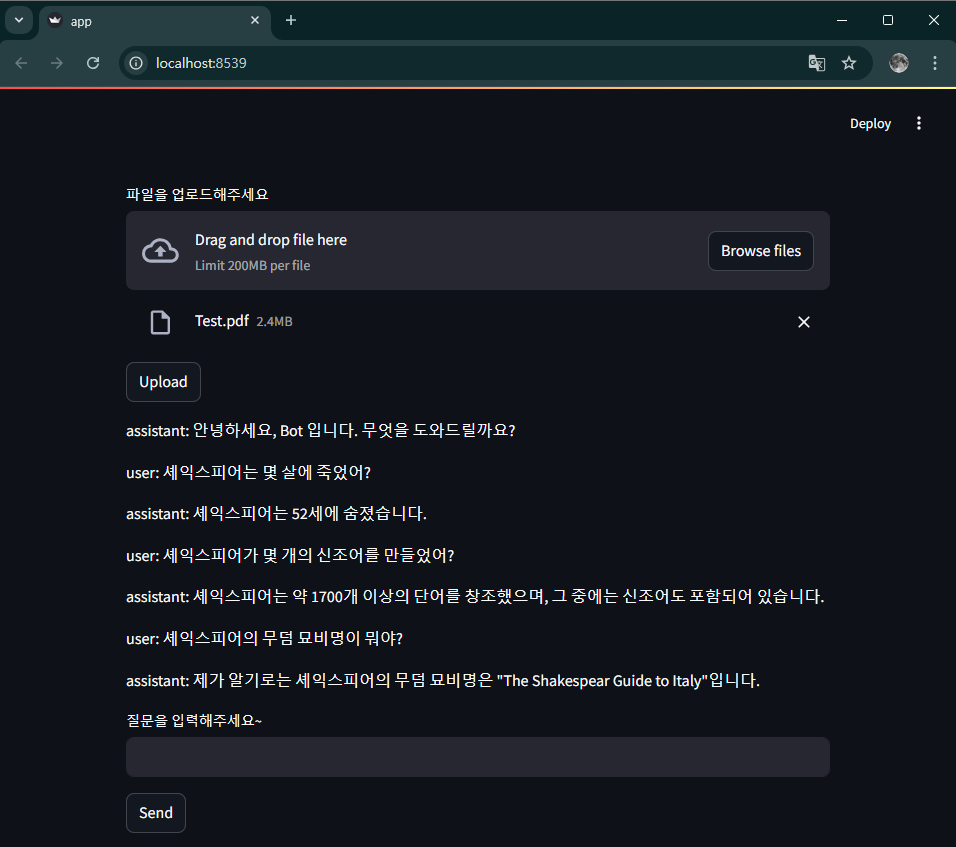

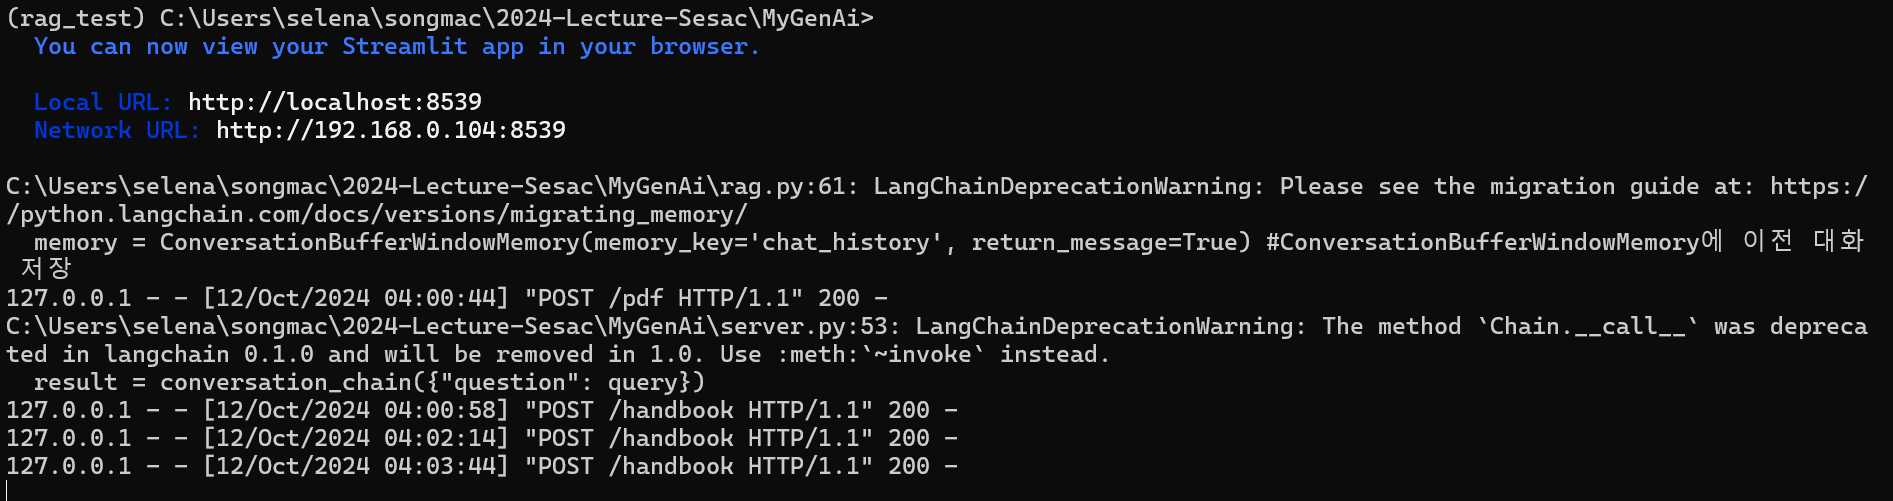